In [ ]:
!rm -rf /content/visual_search

In [ ]:
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import math


# --------------------------------------------------------
# Helper: draw shapes or letters
# --------------------------------------------------------
def draw_item(draw, item, cx, cy, radius):
    """
    item: dict with:
        type: "circle", "square", "triangle", or "letter"
        color: (R,G,B)
        letter: optional (if type == "letter")
        font_path: required if drawing letters
    """
    color = item["color"]
    shape_type = item["type"]

    if shape_type == "circle":
        draw.ellipse(
            (cx - radius, cy - radius, cx + radius, cy + radius),
            fill=color,
        )

    elif shape_type == "square":
        draw.rectangle(
            (cx - radius, cy - radius, cx + radius, cy + radius),
            fill=color,
        )

    elif shape_type == "triangle":
        h = radius * np.sqrt(3)
        pts = [
            (cx, cy - h / 2),
            (cx - radius, cy + h / 2),
            (cx + radius, cy + h / 2),
        ]
        draw.polygon(pts, fill=color)

    elif shape_type == "letter":
        letter = item["letter"]
        font_path = item["font_path"]
        font_size = int(radius * 2.5)
        font = ImageFont.truetype(font_path, font_size)

        # Get tight bounding box of the letter
        bbox = draw.textbbox((0, 0), letter, font=font)
        text_w = bbox[2] - bbox[0]
        text_h = bbox[3] - bbox[1]

        # Correct for bbox origin shift (bbox[0], bbox[1] may be negative)
        offset_x = -bbox[0]
        offset_y = -bbox[1]

        # Compute final top-left pixel such that bbox is truly centered
        x = cx - text_w / 2 + offset_x
        y = cy - text_h / 2 + offset_y

        draw.text((x, y), letter, fill=color, font=font)

    else:
        raise ValueError(f"Unknown item type: {shape_type}")


# --------------------------------------------------------
# Main stimulus generator: supports feature & conjunction search
# --------------------------------------------------------
def generate_visual_search_image(
    img_size=128,
    n_items=12,
    target_present=True,
    target=None,                  # dict defining target features
    distractors=None,             # list of dicts for distractor types
    object_radius=7,
    noise_std=0,
):
    """
    target: dict with fields:
         type = "circle"/"square"/"triangle"/"letter"
         color = (R,G,B)
         letter = optional
         font_path = required for letters

    distractors: list of dicts, same structure as target dict
                 Example:
                 [
                     dict(type="letter", letter="L", color=(255,0,0), font_path="arial.ttf"),
                     dict(type="letter", letter="T", color=(0,0,0), font_path="arial.ttf")
                 ]
    """

    # Create blank white canvas
    img = Image.new("RGB", (img_size, img_size), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Grid layout
    grid_n = math.ceil(math.sqrt(n_items))
    cell_size = img_size / grid_n
    jitter = cell_size * 0.2

    # Pick grid cells
    all_cells = [(i, j) for i in range(grid_n) for j in range(grid_n)]
    chosen_cells = random.sample(all_cells, n_items)

    # Pick location for target if present
    target_index = random.randint(0, n_items - 1)

    # Draw items
    for idx, (i, j) in enumerate(chosen_cells):

        x0 = j * cell_size
        y0 = i * cell_size

        cx = x0 + cell_size/2 + np.random.uniform(-jitter, jitter)
        cy = y0 + cell_size/2 + np.random.uniform(-jitter, jitter)

        if target_present and idx == target_index:
            item = target
        else:
            # randomly pick one distractor type
            item = random.choice(distractors)

        draw_item(draw, item, cx, cy, object_radius)

    # Add gaussian noise
    noise = np.random.normal(0, noise_std, (img_size, img_size, 3))
    arr = np.array(img, dtype=np.float32) + noise
    arr = np.clip(arr, 0, 255).astype(np.uint8)
    img = Image.fromarray(arr)

    return img, int(target_present)


In [ ]:
target = dict(
    type="letter",
    letter="T",
    color=(255, 0, 0),
    font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"
)

distractors = [
    dict(type="letter", letter="L", color=(255, 0, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
    dict(type="letter", letter="T", color=(0, 200, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
]



In [ ]:
distractors = [
    dict(type="letter", letter="L", color=(0, 200, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
]

In [ ]:
target = dict(
    type="square",
    color=(255, 0, 0),
)

distractors = [
    dict(type="circle", color=(255, 0, 0)),
]


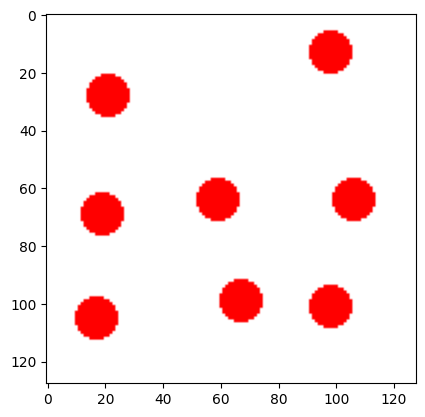

In [ ]:
import matplotlib.pyplot as plt
img, label = generate_visual_search_image(
    n_items=8,
    target_present=False,
    target=target,
    distractors=distractors,
)

plt.imshow(img)
#plt.imshow(digits.data[i].reshape(8,8), cmap='gray_r')
#Image.fromarray(img).show()

In [ ]:
import random
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import math


def generate_dataset(out_dir="visual_search", n_samples=1000):
    os.makedirs(out_dir, exist_ok=True)

    metadata = []

    for i in range(n_samples):
        target_present = random.random() < 0.5

        img, label = generate_visual_search_image(
            n_items=16,
            target_present=target_present,
            target=target,
            distractors=distractors,
        )

        filename = f"{out_dir}/img_{i:04d}.png"
        img.save(filename, "PNG")

        metadata.append((filename, label))

    return metadata


In [ ]:
# @title Default title text
import pandas as pd
import random
import numpy as np
from PIL import Image, ImageDraw
import os

def generate_dataset(out_dir="visual_search", n_samples=125):
    os.makedirs(out_dir, exist_ok=True)
    nested_path = os.path.join(out_dir, "images")
    os.makedirs(nested_path, exist_ok=True)

    metadata = []
    set_sizes = [1,4,8,16]

    #conjunction search:
    s_type = "conj"
    target = dict(
        type="letter",
        letter="T",
        color=(255, 0, 0),
        font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"
    )

    distractors = [
        dict(type="letter", letter="L", color=(255, 0, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
        dict(type="letter", letter="T", color=(0, 200, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
    ]

    for ss in set_sizes:
      for i in range(n_samples):
          target_present = random.random() < 0.5

          img, label = generate_visual_search_image(
              n_items=ss,
              target_present=target_present,
              target=target,
              distractors=distractors,
          )

          filename = f"{out_dir}/images/img_{i:04d}_{ss}_{s_type}.png"
          img.save(filename, "PNG")

          metadata.append({
              "filename": filename,
              "label": label,
              "set_size": ss,
              "search_type": "conjunction",
          })

    #feature search:
    s_type = "feat"
    target = dict(
        type="letter",
        letter="T",
        color=(255, 0, 0),
        font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"
    )

    distractors = [
        dict(type="letter", letter="L", color=(255, 0, 0), font_path="/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf"),
    ]

    for ss in set_sizes:
      for i in range(n_samples):
          target_present = random.random() < 0.5

          img, label = generate_visual_search_image(
              n_items=ss,
              target_present=target_present,
              target=target,
              distractors=distractors,
          )

          filename = f"{out_dir}/images/img_{i:04d}_{ss}_{s_type}.png"
          img.save(filename, "PNG")

          metadata.append({
              "filename": filename,
              "label": label,
              "set_size": ss,
              "search_type": "feature",
          })

    #metadata csv
    df = pd.DataFrame(metadata)
    df.to_csv(f"{out_dir}/metadata.csv", index=False)

    return df

**NO CONJUNCTION SEARCH**

In [ ]:
import pandas as pd
import random
import numpy as np
from PIL import Image, ImageDraw
import os
import random
import os
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import random
import math

def generate_dataset(out_dir="visual_search", n_samples=125):
    os.makedirs(out_dir, exist_ok=True)
    nested_path = os.path.join(out_dir, "images")
    os.makedirs(nested_path, exist_ok=True)

    metadata = []
    set_sizes = [1,4,8,16]

    #feature search:
    s_type = "feat"
    target = dict(
        type="square",
        color=(255, 0, 0),
    )

    distractors = [
        dict(type="circle", color=(255, 0, 0)),
    ]

    for ss in set_sizes:
      for i in range(n_samples):
          target_present = random.random() < 0.5

          img, label = generate_visual_search_image(
              n_items=ss,
              target_present=target_present,
              target=target,
              distractors=distractors,
          )

          filename = f"{out_dir}/images/img_{i:04d}_{ss}_{s_type}.png"
          img.save(filename, "PNG")

          metadata.append({
              "filename": filename,
              "label": label,
              "set_size": ss,
              "search_type": "feature",
          })

    #metadata csv
    df = pd.DataFrame(metadata)
    df.to_csv(f"{out_dir}/metadata.csv", index=False)

    return df

In [ ]:
md = generate_dataset(n_samples=250)

In [ ]:
print(len(md))

1000


In [ ]:
print(md)

                                      filename  label  set_size search_type
0     visual_search/images/img_0000_1_feat.png      0         1     feature
1     visual_search/images/img_0001_1_feat.png      1         1     feature
2     visual_search/images/img_0002_1_feat.png      0         1     feature
3     visual_search/images/img_0003_1_feat.png      0         1     feature
4     visual_search/images/img_0004_1_feat.png      1         1     feature
..                                         ...    ...       ...         ...
995  visual_search/images/img_0245_16_feat.png      1        16     feature
996  visual_search/images/img_0246_16_feat.png      1        16     feature
997  visual_search/images/img_0247_16_feat.png      1        16     feature
998  visual_search/images/img_0248_16_feat.png      0        16     feature
999  visual_search/images/img_0249_16_feat.png      1        16     feature

[1000 rows x 4 columns]


In [ ]:
import numpy as np
from PIL import Image
import os

def load_visual_search_as_digits_like(df, img_dir, img_size=(128,128), grayscale=True):
    data = []
    targets = []
    images = []

    for _, row in df.iterrows():
        #img_path = os.path.join(img_dir, row["filename"])
        img_path = row["filename"]

        img = Image.open(img_path)
        if grayscale:
            img = img.convert("L")

        img = img.resize(img_size)
        img_arr = np.array(img)

        images.append(img_arr)
        data.append(img_arr.flatten())
        targets.append(row["label"])

    return {
        "data": np.array(data),
        "target": np.array(targets),
        "images": np.array(images)
    }


In [ ]:
vs = load_visual_search_as_digits_like(
    md,
    img_dir="/content/visual_search/images"
)


In [ ]:
vs["target"]

array([0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse_output=False)
y_onehot = enc.fit_transform(vs["target"].reshape(-1, 1))
y_onehot

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]])

In [ ]:
x = vs["data"]
y = y_onehot

In [ ]:
import sklearn.model_selection
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    learning_rate_init=1e-3,
    max_iter=1000,
    early_stopping=True,
    random_state=0
)
#input normalization
X_train = x_train / 255.0
X_test  = x_test  / 255.0

In [ ]:
mlp.fit(x_train, y_train)

MLPClassifier(early_stopping=True, hidden_layer_sizes=(128, 64), max_iter=1000,
              random_state=0)

In [ ]:
output = mlp.predict(x_test)

In [ ]:
acc = np.mean(output == y_test)

print(acc)

0.47


In [ ]:
np.mean(y_test)

np.float64(0.5)

In [ ]:
rmse = np.sqrt(np.mean((y_test-output)**2))
print(rmse)

0.7280109889280518


In [ ]:
mlp.loss_curve_[:10], mlp.loss_curve_[-10:]


([np.float64(36.08879735603384),
  np.float64(36.9448420363382),
  np.float64(34.24156942064918),
  np.float64(35.943631664430704),
  np.float64(32.19561155920812),
  np.float64(37.545571980207995),
  np.float64(35.286101250806524),
  np.float64(34.2415692642026),
  np.float64(34.30711448046447),
  np.float64(33.209223504399645)],
 [np.float64(35.943631664430704),
  np.float64(32.19561155920812),
  np.float64(37.545571980207995),
  np.float64(35.286101250806524),
  np.float64(34.2415692642026),
  np.float64(34.30711448046447),
  np.float64(33.209223504399645),
  np.float64(34.94309542640369),
  np.float64(29.924228530358253),
  np.float64(33.135525179276925)])

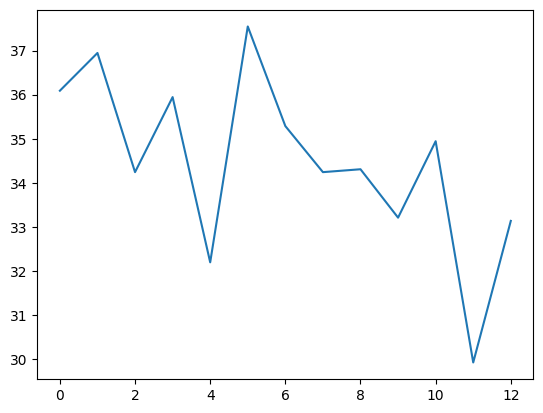

In [ ]:
plt.plot(mlp.loss_curve_)

In [ ]:
import scipy
features = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
iters = 10
ci_low_vals = []
ci_high_vals = []

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True,
)
x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=True,
)

for f in features:
  rmse_vals = []
  for i in range(iters):
    x = vs["data"]
    y = y_onehot

    x_train, x_valid, y_train, y_valid = sklearn.model_selection.train_test_split(
        X_train, Y_train, test_size=0.2, shuffle=True,
    )

    mlp = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(f,f), # f hidden layers with f features
                                              activation='relu',        # rectified linear
                                              learning_rate_init=1e-2,  # learning rate
                                              max_iter=1000,            # number of iterations
                                              early_stopping=True,      # stop training if validation data gets worse
                                              random_state=i)           # random number seed for initialization

    mlp.fit(x_train, y_train)

    output = mlp.predict(x_valid)

    rmse = np.sqrt(np.mean((y_valid-output)**2))

    rmse_vals.append(rmse)

  ci_low, ci_high = scipy.stats.bootstrap([rmse_vals], np.mean).confidence_interval
  ci_low_vals.append(ci_low)
  ci_high_vals.append(ci_high)

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perce

Text(0, 0.5, 'RMSE')

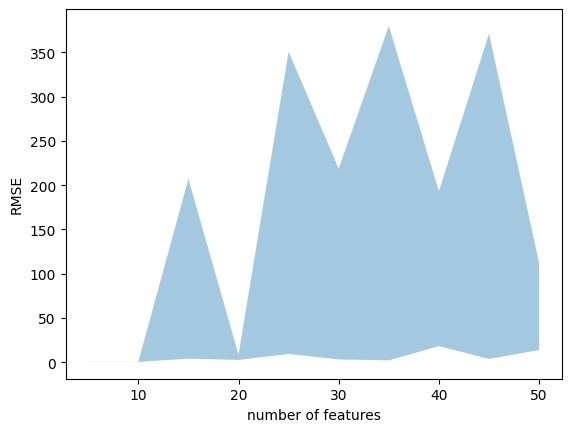

In [ ]:
plt.fill_between(features, ci_low_vals, ci_high_vals, alpha=0.4)
plt.xlabel('number of features')
plt.ylabel('RMSE')

In [ ]:
mlp = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(20,20), # f hidden layers with f features
                                              activation='relu',        # rectified linear
                                              learning_rate_init=1e-2,  # learning rate
                                              max_iter=1000,            # number of iterations
                                              early_stopping=True,      # stop training if validation data gets worse
                                              random_state=i)           # random number seed for initialization

mlp.fit(x_train, y_train)

output = mlp.predict(x_test)
rmse = np.sqrt(np.mean((y_test-output)**2))
print(rmse)

7.879446995102946


In [ ]:
acc = np.mean(output == y_test)
print(acc)

0.0


In [ ]:
#SVM with Gaussian radial basis, different c and g values
#digits = sklearn.datasets.load_digits()
x = vs["data"]
y = vs['target']
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True,
)
X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=True,
)

Cs = np.logspace(-7, 5, 10)
#gammas = np.logspace(-6, 3, 5)
gammas = np.logspace(-10, 3, 10)
acc_total_lst = []
for c in Cs:
  acc_gs = []
  for g in gammas:
    #acc_lst = []
    #for i in range(40):
    svm = sklearn.svm.SVC(kernel='rbf', gamma=g, C=c)
    svm.fit(X_train, Y_train)
    output = svm.predict(X_valid)
    value = svm.decision_function(X_valid)
    acc = np.mean(output == Y_valid)
    #acc_lst.append(acc)

    #acc_array = np.array(acc_lst)
    #avg_acc = np.average(acc_array)
    acc_gs.append(acc)
  acc_total_lst.append(acc_gs)
acc_total_array = np.array(acc_total_lst)

KeyboardInterrupt: 

([<matplotlib.axis.YTick at 0x7c6fe1d87500>,
 [Text(0, 0, '1e-07'),
  Text(0, 3, '0.001'),
  Text(0, 6, '10.0'),
  Text(0, 9, '100000.0')])

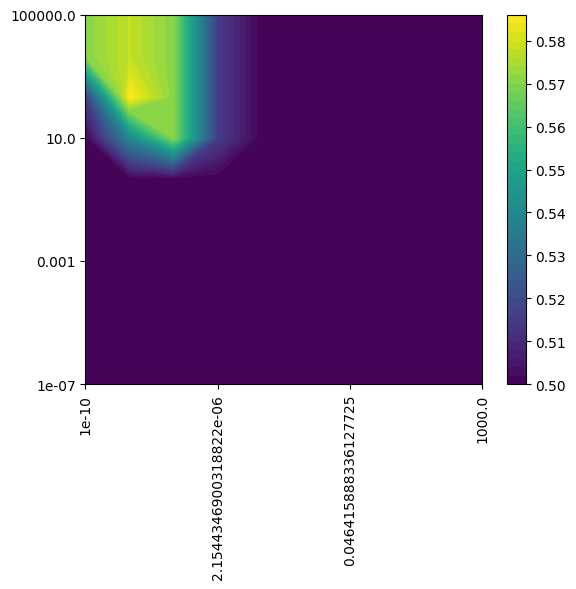

In [ ]:
XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(Cs)))
plt.contourf(XX, YY, acc_total_array, levels=50)
plt.colorbar()
CS = plt.contour(XX, YY, acc_total_array, levels=[0,0.75,0.8,0.85, 0.9, 0.95], colors='k')
plt.clabel(CS, CS.levels, inline=True, fontsize=8)
plt.xticks(np.arange(len(gammas))[::3], gammas[::3], rotation=90)
plt.yticks(np.arange(len(Cs))[::3], Cs[::3])

In [ ]:
(1e-10 + 2.15e-6)/2

1.07505e-06

In [ ]:
(10 + 100000)/2

50005.0

In [ ]:
#chosen parameters
c = 1000
g = 1e-09
svm = sklearn.svm.SVC(kernel='rbf', gamma=g, C=c)
svm.fit(X_train, Y_train)
output = svm.predict(X_test)
acc = np.mean(output == Y_test)
print(f'accuracy is: {acc}')

accuracy is: 0.55


([<matplotlib.axis.YTick at 0x7c6fe5f0f500>,
 [Text(0, 0, '1.0'), Text(0, 3, '3.1622776601683795'), Text(0, 6, '10.0')])

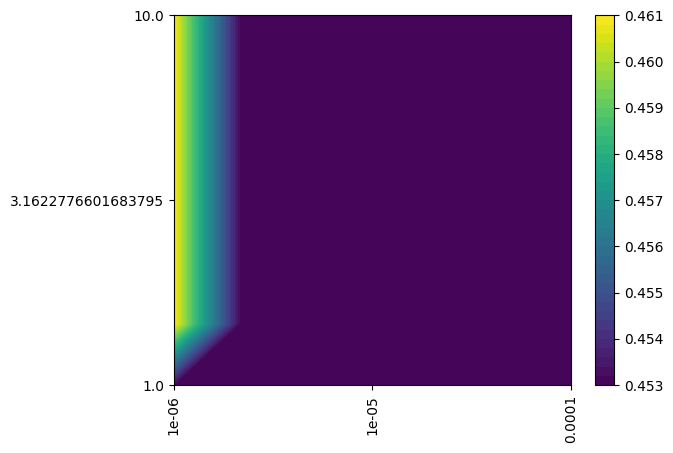

In [ ]:
Cs = np.logspace(0, 1, 7)    # 1 → 10
gammas = np.logspace(-10, -6, 7)
x = vs["data"]
y = vs['target']
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True,
)
X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=True,
)


acc_total_lst = []
for c in Cs:
  acc_gs = []
  for g in gammas:
    #acc_lst = []
    #for i in range(40):
    svm = sklearn.svm.SVC(kernel='rbf', gamma=g, C=c)
    svm.fit(X_train, Y_train)
    output = svm.predict(X_valid)
    value = svm.decision_function(X_valid)
    acc = np.mean(output == Y_valid)
    #acc_lst.append(acc)

    #acc_array = np.array(acc_lst)
    #avg_acc = np.average(acc_array)
    acc_gs.append(acc)
  acc_total_lst.append(acc_gs)
acc_total_array = np.array(acc_total_lst)


XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(Cs)))
plt.contourf(XX, YY, acc_total_array, levels=50)
plt.colorbar()
CS = plt.contour(XX, YY, acc_total_array, levels=[0,0.75,0.8,0.85, 0.9, 0.95], colors='k')
plt.clabel(CS, CS.levels, inline=True, fontsize=8)
plt.xticks(np.arange(len(gammas))[::3], gammas[::3], rotation=90)
plt.yticks(np.arange(len(Cs))[::3], Cs[::3])

([<matplotlib.axis.YTick at 0x7b74684903b0>,
 [Text(0, 0, '10.0'), Text(0, 3, '1000.0'), Text(0, 6, '100000.0')])

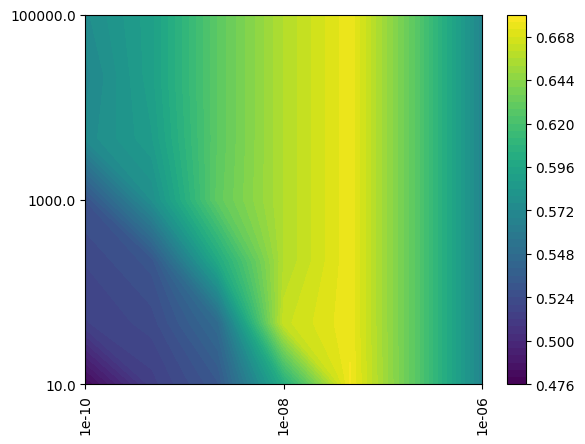

In [ ]:
Cs = np.logspace(1, 5, 7)    # 1 → 10
gammas = np.logspace(-10, -6, 7)
x = vs["data"]
y = vs['target']
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True,
)
X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=True,
)


acc_total_lst = []
for c in Cs:
  acc_gs = []
  for g in gammas:
    #acc_lst = []
    #for i in range(40):
    svm = sklearn.svm.SVC(kernel='rbf', gamma=g, C=c)
    svm.fit(X_train, Y_train)
    output = svm.predict(X_valid)
    value = svm.decision_function(X_valid)
    acc = np.mean(output == Y_valid)
    #acc_lst.append(acc)

    #acc_array = np.array(acc_lst)
    #avg_acc = np.average(acc_array)
    acc_gs.append(acc)
  acc_total_lst.append(acc_gs)
acc_total_array = np.array(acc_total_lst)


XX, YY = np.meshgrid(np.arange(len(gammas)), np.arange(len(Cs)))
plt.contourf(XX, YY, acc_total_array, levels=50)
plt.colorbar()
CS = plt.contour(XX, YY, acc_total_array, levels=[0,0.75,0.8,0.85, 0.9, 0.95], colors='k')
plt.clabel(CS, CS.levels, inline=True, fontsize=8)
plt.xticks(np.arange(len(gammas))[::3], gammas[::3], rotation=90)
plt.yticks(np.arange(len(Cs))[::3], Cs[::3])

In [ ]:
x = vs["data"]
y = vs['target']
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True,
)
X_train, X_valid, Y_train, Y_valid = sklearn.model_selection.train_test_split(
    X_train, Y_train, test_size=0.2, shuffle=True,
)

In [ ]:
(1e-08 + 1e-06)/2

5.049999999999999e-07

In [ ]:
(1e-08 + 5.049999999999999e-07)/2

2.5749999999999997e-07

In [ ]:
#chosen parameters
c = 1000
g = 1e-07
svm = sklearn.svm.SVC(kernel='rbf', gamma=g, C=c)
svm.fit(X_train, Y_train)
output = svm.predict(X_test)
acc = np.mean(output == Y_test)
print(f'accuracy is: {acc}')

accuracy is: 0.6325


In [ ]:
x = vs["data"]
y = vs['target']

In [ ]:
import sklearn.model_selection
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=0
)

In [ ]:
from sklearn.svm import SVC

clf = SVC(kernel="rbf", C=10, gamma="scale")
clf.fit(x_train, y_train)
output = mlp.predict(x_test)
rmse = np.sqrt(np.mean((y_test-output)**2))
print(rmse)

ValueError: operands could not be broadcast together with shapes (200,) (200,2) 

In [ ]:
import sklearn.model_selection
import scipy
import matplotlib.pyplot as plt
features = [50,75,100,125,150,175,200]
iters = 10
ci_low_vals = []
ci_high_vals = []
avg_vals = []

for f in features:
  acc_vals = []
  for i in range(iters):
    #digits = sklearn.datasets.load_digits()

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
        vs["data"], y_onehot, test_size=0.2, shuffle=True, random_state=i
    )

    mlp = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(f,30), # f hidden layer with f features
                                           activation='relu',        # rectified linear
                                           learning_rate_init=1e-2,  # learning rate
                                           max_iter=1000,            # number of iterations
                                           early_stopping=True,      # stop training if validation data gets worse
                                           random_state=i)           # random number seed for initialization

    mlp.fit(x_train, y_train)

    output = mlp.predict(x_test)

    acc = np.mean(output == y_test)

    acc_vals.append(acc)

  ci_low, ci_high = scipy.stats.bootstrap([acc_vals], np.mean).confidence_interval
  ci_low_vals.append(ci_low)
  ci_high_vals.append(ci_high)

Text(0, 0.5, 'RMSE')

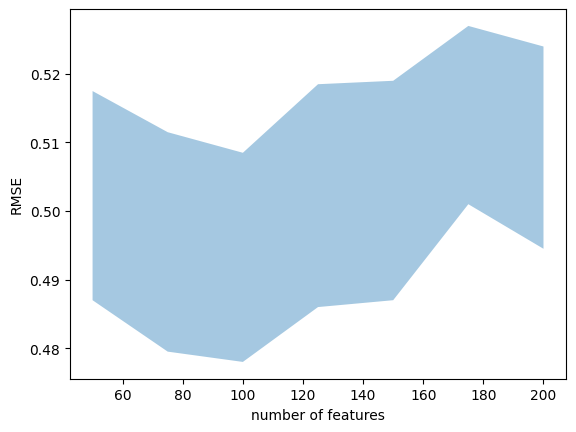

In [ ]:
plt.fill_between(features, ci_low_vals, ci_high_vals, alpha=0.4)
plt.xlabel('number of features')
plt.ylabel('RMSE')

In [ ]:
!rm -rf /content/visual_search